# Log

* Written by HongYongGi / email : hyg4438@gmail.com
* Written date : 20231107
---
# Code desc

* X-ray 사진에서 Class가 Imbalance 한 문제를 해결하고자 각각의 class 학습에 각기 다른 loss weight을 조정하는 기법으로 학습을 진행하고자 함

---

## Import Package


In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from operator import itemgetter
from collections import OrderedDict

from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch import optim,nn
import torch.nn.functional as F
from torchvision import transforms as T,models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

pd.options.plotting.backend = "plotly"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import gc
gc.collect()
torch.cuda.empty_cache()


---
# Utils function


In [2]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequencies for each class.
    Parameters:
        labels: labels for each image
    Returns:
        positive_frequencies: a numpy array of the frequencies of positive examples per class
        negative_frequencies: a numpy array of the frequencies of negative examples per class  
    """
    labels = np.array(labels)
    N = labels.shape[0]

    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

def weighted_loss(pos_weights, neg_weights, y_pred, y_true, epsilon=1e-7):
    """
    Compute the weighted loss for a batch of examples.
    Parameters:
        pos_weights: weights for positive examples, of shape [num_classes]
        neg_weights: weights for negative examples, of shape [num_classes]
        y_pred: a torch tensor of shape (batch_size, num_classes) that contains 
                the prediction for each class
        y_true: a torch tensor of shape (batch_size, num_classes) that contains 
                the correct labels for each class
        epsilon: small number to prevent division by zero
    Returns:    
        loss: the combined weighted loss for all examples    
    
    """
    loss = 0.0
    for i in range(len(pos_weights)):
        loss_pos = -1 * torch.mean(pos_weights[i] * y_true[:,i] * torch.log(y_pred[:,i] + epsilon))
        loss_neg = -1 * torch.mean(neg_weights[i] * (1-y_true[:,i]) * torch.log((1-y_pred[:,i]) + epsilon))
        loss += loss_pos + loss_neg
    return loss

def deprocess(img):
    """
    Undo the preprocessing done by torchvision.
    Parameters:
        img: a torch tensor of shape (3, H, W) that contains the preprocessed image
    Returns:
        img: a torch tensor of shape (H, W, 3) that contains the deprocessed image

    """
    img = img.permute(1,2,0)
    img = img * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
    return img



def class_accuracy(dataloader, model):
    """
    Compute the accuracy per class.
    Parameters:
        dataloader: a DataLoader object to iterate over some dataset
        model: a torch nn.Module object, with a .forward() method that outputs logits
    Returns:
        per_class_accuracy: a list of accuracies for each class, in the order they appear in pathology_list
    """
    per_class_accuracy = [0 for i in range(len(pathology_list))]
    total = 0.0

    with torch.no_grad():
        for images,labels in dataloader:
            ps = model(images.to(device))
            labels = labels.to(device)
            ps = (ps >= 0.5).float()

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(dataloader.dataset))*100.0 for i in per_class_accuracy]

    return per_class_accuracy     


def get_acc_data(class_names,acc_list):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Acc']) 
    return df 


def view_classify(img, ps, label):

    class_name = pathology_list
    classes = np.array(class_name)

    ps = ps.cpu().data.numpy().squeeze()
    img = deprocess(img)
    class_labels = list(np.where(label==1)[0])

    if not class_labels :
        title = 'No Findings'
    else : 
        title = itemgetter(*class_labels)(class_name)


    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(title))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None





---
# Class Information Analysis

In [3]:
# Information CSV file load
data = pd.read_csv('../../archive/sample_labels.csv')


In [4]:
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']

for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
data['No Findings'] = data['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)
data = data.drop(list(data.iloc[:,1:11].columns.values),axis = 1)

data = data.drop(['No Findings'],axis = 1)
data.iloc[:,1:].sum().plot.barh()

* 위의 도표를 보았을 때 각각의 class가 imbalance하게 되어 있는 것을 확인 할 수 있음.


In [5]:
freq_pos,freq_neg = compute_class_freqs(data.iloc[:,1:])

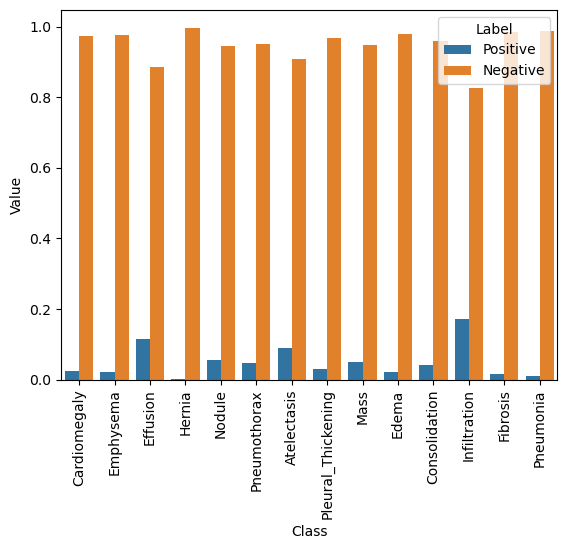

In [6]:
df = pd.DataFrame({"Class": pathology_list, "Label": "Positive", "Value": freq_pos})
df_neg = pd.DataFrame([{"Class": pathology_list[l], "Label": "Negative", "Value": v} for l, v in enumerate(freq_neg)])
df = pd.concat([df, df_neg], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=df)

In [7]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

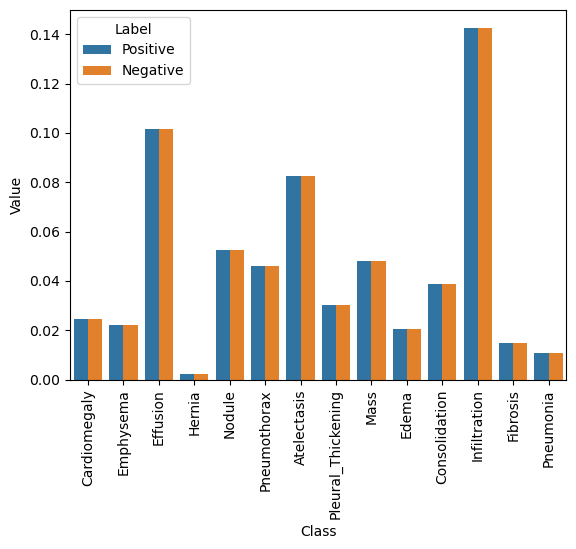

In [8]:
df = pd.DataFrame({"Class": pathology_list, "Label": "Positive", "Value": pos_contribution})
df_neg = pd.DataFrame([{"Class": pathology_list[l], "Label": "Negative", "Value": v} for l, v in enumerate(neg_contribution)])
df = pd.concat([df, df_neg], ignore_index=True)

plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=df)

---
# Data Load & Applying Transforms

In [9]:
class NIH_Dataset(Dataset):

    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir 
        self.transform = transform 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_file = self.img_dir + self.data.iloc[:,0][idx]
        img = Image.open(img_file).convert('RGB')
        label = np.array(self.data.iloc[:,1:].iloc[idx])

        if self.transform:
            img = self.transform(img)

        return img,label

In [10]:
data_transform = T.Compose([
    T.RandomRotation((-20,+20)),
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])


In [11]:
trainds = NIH_Dataset(data,
                      img_dir = '../../archive/sample/sample/images/',
                      transform = data_transform)

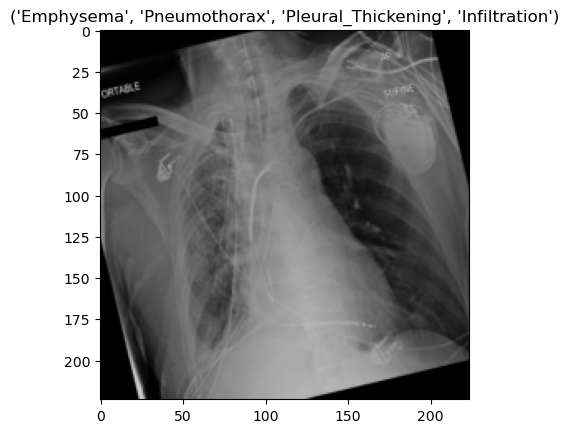

In [12]:
image, label = trainds[0]
class_labels = list(np.where(label==1)[0])
plt.imshow(deprocess(image))
plt.title(itemgetter(*class_labels)(pathology_list));

In [13]:
trainset, validset, testset = random_split(trainds, [5000,303,303])

print("Length of trainset : {}".format(len(trainset)))
print("Length of testset : {}".format(len(testset)))
print("Length of validset : {}".format(len(validset)))

Length of trainset : 5000
Length of testset : 303
Length of validset : 303


In [14]:
trainloader = DataLoader(trainset,
                         batch_size = 640,
                         shuffle = True)

validloader = DataLoader(validset,
                         batch_size = 320,
                         shuffle = False)

testloader = DataLoader(testset,
                        batch_size = 320,
                        shuffle = True)

---
# Base Model Define

In [15]:

base_model = models.resnet18()
for param in base_model.parameters():
    param.requires_grad = False

base_model.fc = nn.Sequential(
    nn.Linear(512, 14),
    nn.Sigmoid()
)

base_model.to(device)
optimizer = optim.Adam(base_model.parameters(),lr = 0.0001)


In [16]:
optimizer = optim.Adam(base_model.parameters(),lr = 0.0001)

schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 factor = 0.1,
                                                 patience = 4)
epochs = 300
valid_loss_min = np.Inf

In [17]:
base_neg_weights = np.zeros(neg_weights.shape)
base_pos_weights = np.ones(pos_weights.shape)   

In [18]:
with open('base_training_log.txt', 'w') as f:
    for i in range(epochs):

        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0 

        base_model.train()
        for images,labels in tqdm(trainloader):
            images = images.to(device)
            labels = labels.to(device)

            ps = base_model(images)
            loss = weighted_loss(base_pos_weights,base_neg_weights,ps,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        avg_train_loss = train_loss / len(trainloader)

        base_model.eval()
        with torch.no_grad():
            for images,labels in tqdm(validloader):
                images = images.to(device)
                labels = labels.to(device)

                ps = base_model(images)
                loss = weighted_loss(base_pos_weights,base_neg_weights,ps,labels)
                valid_loss += loss.item()
            avg_valid_loss = valid_loss / len(validloader)

        schedular.step(avg_valid_loss)

        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : base_model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'base_Pneumonia_model.pt')

            valid_loss_min = avg_valid_loss

        print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
        print("Epoch : {} Valid Loss : {:.6f} ".format(i+1,avg_valid_loss))
        
        # Write training log to file
        f.write("Epoch : {} Train Loss : {:.6f}\n".format(i+1,avg_train_loss))
        f.write("Epoch : {} Valid Loss : {:.6f}\n".format(i+1,avg_valid_loss))


 50%|█████     | 4/8 [00:57<00:58, 14.50s/it]

### Class Accuracy

In [ ]:
print("Train Dataset Accuracy Report")
acc_list = class_accuracy(trainloader, base_model)
get_acc_data(pathology_list,acc_list)

Train Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,2.44
1,Emphysema,2.40
2,Effusion,11.58
3,Hernia,0.26
4,Nodule,5.68
5,Pneumothorax,4.84
6,Atelectasis,9.14
7,Pleural_Thickening,3.08
8,Mass,4.94
9,Edema,2.04


In [ ]:
print("Base model - Test Dataset Accuracy Report")
acc_list = class_accuracy(testloader, base_model)
get_acc_data(pathology_list,acc_list)

Test Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,4.290429
1,Emphysema,0.330033
2,Effusion,7.260726
3,Hernia,0.000000
4,Nodule,5.280528
5,Pneumothorax,4.620462
6,Atelectasis,7.920792
7,Pleural_Thickening,3.630363
8,Mass,4.950495
9,Edema,2.970297


In [ ]:
print("Valid Dataset Accuracy Report")
acc_list = class_accuracy(validloader, base_model)
get_acc_data(pathology_list,acc_list)

Valid Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,1.980198
1,Emphysema,1.980198
2,Effusion,14.191419
3,Hernia,0.000000
4,Nodule,4.290429
5,Pneumothorax,4.950495
6,Atelectasis,8.910891
7,Pleural_Thickening,3.630363
8,Mass,7.260726
9,Edema,2.310231


# Plot Results


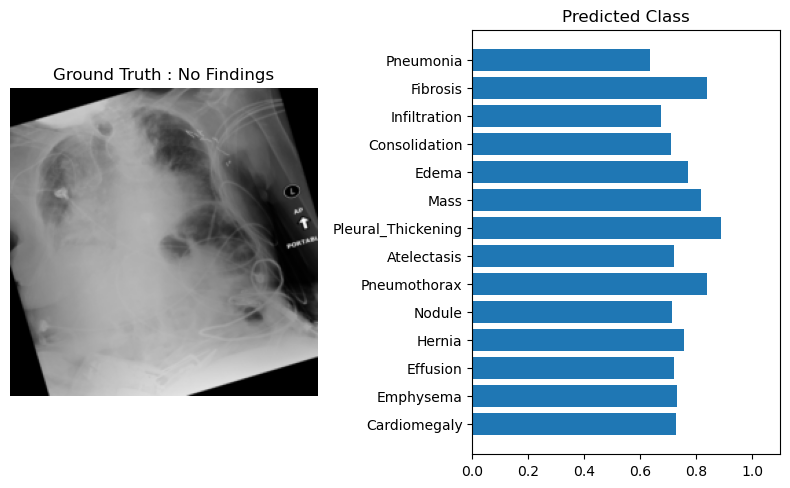

In [ ]:
image,label = testset[123]

ps = base_model(image.unsqueeze(0).to(device))

view_classify(image,ps,label)

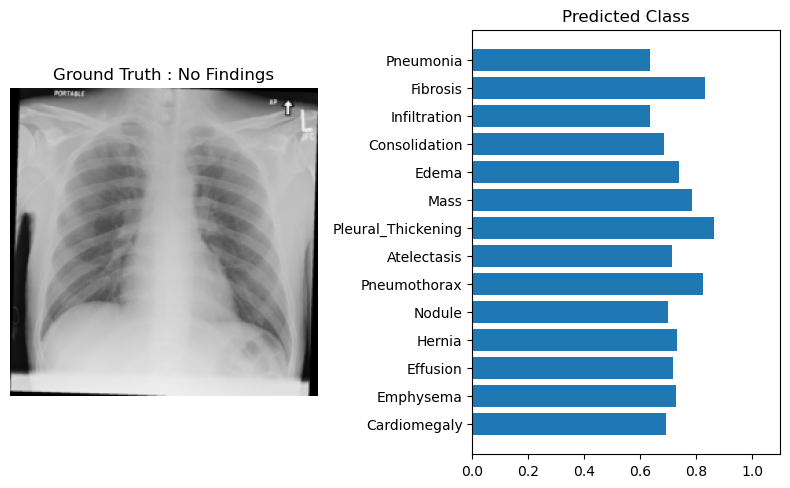

In [ ]:
image,label = trainset[999]

ps = base_model(image.unsqueeze(0).to(device))

view_classify(image,ps,label)

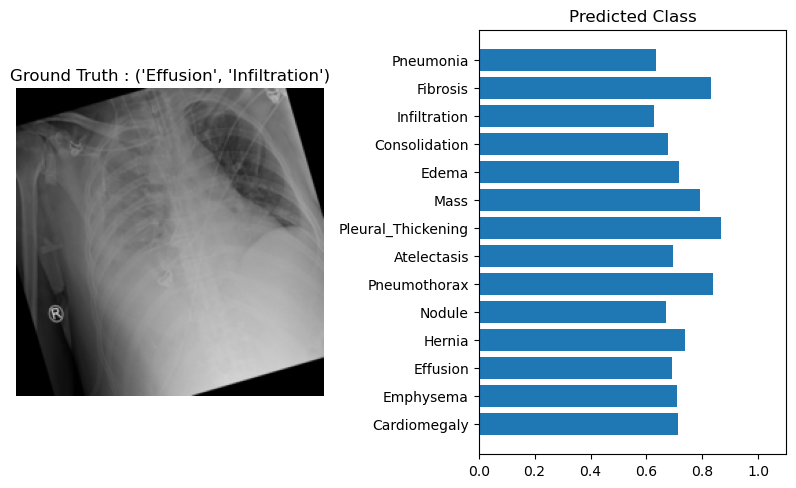

In [ ]:
image,label = validset[234]

ps = base_model(image.unsqueeze(0).to(device))

view_classify(image,ps,label)

---
# Loss Weight 조정 Model Define

In [ ]:

model = models.resnet18()
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Sequential(
    nn.Linear(512, 14),
    nn.Sigmoid()
)

model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
optimizer = optim.Adam(model.parameters(),lr = 0.0001)

schedular = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                 factor = 0.1,
                                                 patience = 4)
valid_loss_min = np.Inf

In [ ]:
with open('training_log.txt', 'w') as f:
    for i in range(epochs):

        train_loss = 0.0
        valid_loss = 0.0
        train_acc = 0.0
        valid_acc = 0.0 

        model.train()
        for images,labels in tqdm(trainloader):
            images = images.to(device)
            labels = labels.to(device)

            ps = model(images)
            loss = weighted_loss(pos_weights,neg_weights,ps,labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        avg_train_loss = train_loss / len(trainloader)

        model.eval()
        with torch.no_grad():
            for images,labels in tqdm(validloader):
                images = images.to(device)
                labels = labels.to(device)

                ps = model(images)
                loss = weighted_loss(pos_weights,neg_weights,ps,labels)
                valid_loss += loss.item()
            avg_valid_loss = valid_loss / len(validloader)

        schedular.step(avg_valid_loss)

        if avg_valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).   Saving model ...'.format(valid_loss_min,avg_valid_loss))
            torch.save({
                'epoch' : i,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict' : optimizer.state_dict(),
                'valid_loss_min' : avg_valid_loss
            },'Pneumonia_model.pt')

            valid_loss_min = avg_valid_loss

        print("Epoch : {} Train Loss : {:.6f} ".format(i+1,avg_train_loss))
        print("Epoch : {} Valid Loss : {:.6f} ".format(i+1,avg_valid_loss))
        
        # Write training log to file
        f.write("Epoch : {} Train Loss : {:.6f}\n".format(i+1,avg_train_loss))
        f.write("Epoch : {} Valid Loss : {:.6f}\n".format(i+1,avg_valid_loss))


100%|██████████| 1/1 [00:06<00:00,  6.04s/it]


Validation loss decreased (inf --> 0.908011).   Saving model ...
Epoch : 1 Train Loss : 0.899057 
Epoch : 1 Valid Loss : 0.908011 


100%|██████████| 1/1 [00:06<00:00,  6.05s/it]


Validation loss decreased (0.908011 --> 0.904892).   Saving model ...
Epoch : 2 Train Loss : 0.887999 
Epoch : 2 Valid Loss : 0.904892 


100%|██████████| 1/1 [00:06<00:00,  6.05s/it]


Epoch : 3 Train Loss : 0.884274 
Epoch : 3 Valid Loss : 0.907528 


100%|██████████| 1/1 [00:06<00:00,  6.06s/it]


Epoch : 4 Train Loss : 0.885749 
Epoch : 4 Valid Loss : 0.908487 


100%|██████████| 1/1 [00:06<00:00,  6.05s/it]

Epoch : 5 Train Loss : 0.883481 
Epoch : 5 Valid Loss : 0.906527 


### Class Accuracy

In [ ]:
def class_accuracy(dataloader, model):

    per_class_accuracy = [0 for i in range(len(pathology_list))]
    total = 0.0

    with torch.no_grad():
        for images,labels in dataloader:
            ps = model(images.to(device))
            labels = labels.to(device)
            ps = (ps >= 0.5).float()

            for i in range(ps.shape[1]):
                x1 = ps[:,i:i+1]
                x2 = labels[:,i:i+1]
                per_class_accuracy[i] += int((x1 == x2).sum())

        per_class_accuracy = [(i/len(dataloader.dataset))*100.0 for i in per_class_accuracy]

    return per_class_accuracy     


def get_acc_data(class_names,acc_list):
    df = pd.DataFrame(list(zip(class_names, acc_list)), columns =['Labels', 'Acc']) 
    return df 

In [ ]:
print("Train Dataset Accuracy Report")
acc_list = class_accuracy(trainloader, model)
get_acc_data(pathology_list,acc_list)

Train Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,80.20
1,Emphysema,13.90
2,Effusion,39.70
3,Hernia,8.96
4,Nodule,78.46
5,Pneumothorax,33.32
6,Atelectasis,12.88
7,Pleural_Thickening,78.24
8,Mass,6.76
9,Edema,18.32


In [ ]:
print("Loss Weight model - Test Dataset Accuracy Report")
acc_list = class_accuracy(testloader, model)
get_acc_data(pathology_list,acc_list)

Test Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,76.237624
1,Emphysema,10.891089
2,Effusion,39.933993
3,Hernia,10.891089
4,Nodule,77.887789
5,Pneumothorax,30.693069
6,Atelectasis,10.891089
7,Pleural_Thickening,76.237624
8,Mass,5.610561
9,Edema,20.792079


In [ ]:
print("Valid Dataset Accuracy Report")
acc_list = class_accuracy(validloader, model)
get_acc_data(pathology_list,acc_list)

Valid Dataset Accuracy Report


,Labels,Acc
0,Cardiomegaly,79.537954
1,Emphysema,15.841584
2,Effusion,45.214521
3,Hernia,8.910891
4,Nodule,75.907591
5,Pneumothorax,37.623762
6,Atelectasis,13.861386
7,Pleural_Thickening,79.537954
8,Mass,10.561056
9,Edema,20.462046


# Plot Results


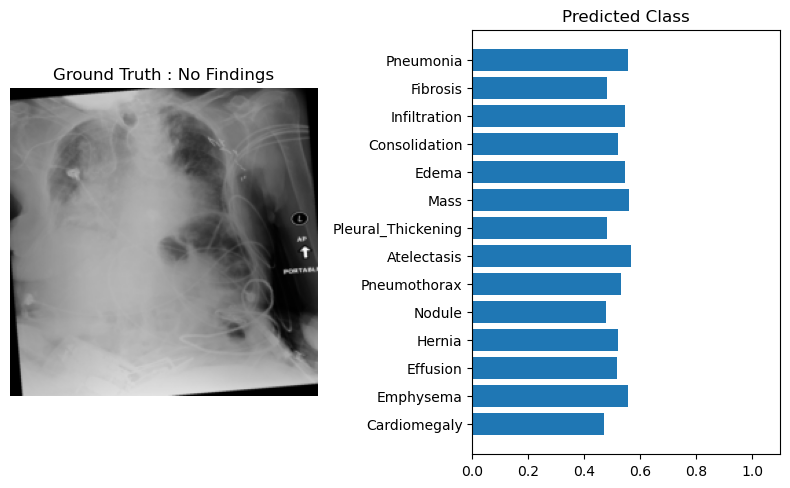

In [ ]:
image,label = testset[123]

ps = model(image.unsqueeze(0).to(device))

view_classify(image,ps,label)

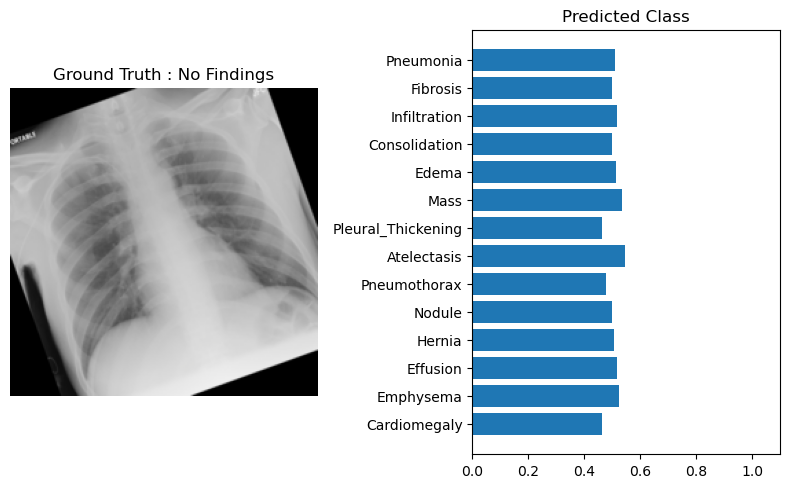

In [ ]:
image,label = trainset[999]

ps = model(image.unsqueeze(0).to(device))

view_classify(image,ps,label)

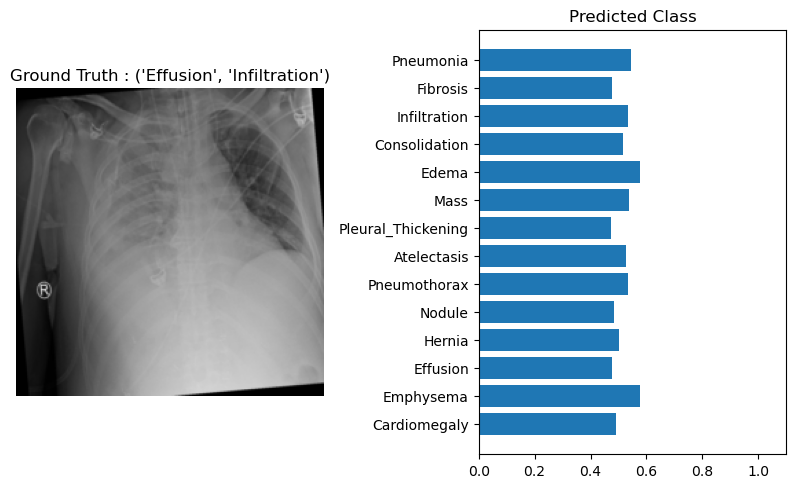

In [ ]:
image,label = validset[234]

ps = model(image.unsqueeze(0).to(device))

view_classify(image,ps,label)

---

# Result


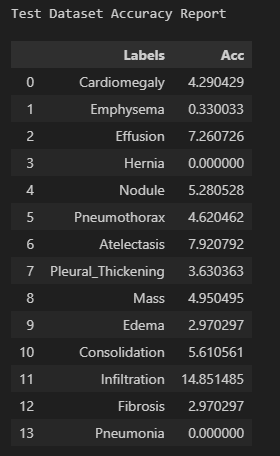
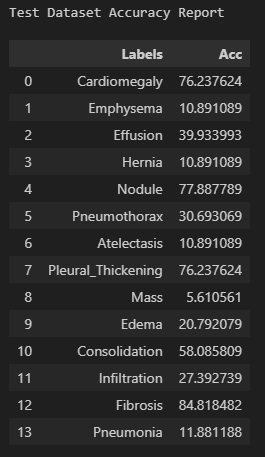

* Test dataset의 결과를 보았을 때 loss Weight을 조정한 모델의 성능을 보았을 때 확연하게 성능이 올라 간 것을 볼 수 있다.

---